In [ ]:
from openai import OpenAI

# API configuration
api_key = 'd20572310bbacaf2823af34cecd24a42'

base_url = 'https://chat-ai.academiccloud.de/v1'

# Initialize client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

models = client.models.list()

# Print all available model IDs
for model in models.data:
    print(model.id)


qwen3-coder-30b-a3b-instruct
meta-llama-3.1-8b-instruct
openai-gpt-oss-120b
gemma-3-27b-it
qwen3-30b-a3b-thinking-2507
qwen3-30b-a3b-instruct-2507
qwen3-32b
qwen3-235b-a22b
llama-3.3-70b-instruct
qwen2.5-vl-72b-instruct
medgemma-27b-it
qwq-32b
deepseek-r1
deepseek-r1-distill-llama-70b
mistral-large-instruct
qwen2.5-coder-32b-instruct
internvl2.5-8b
teuken-7b-instruct-research
codestral-22b
llama-3.1-sauerkrautlm-70b-instruct
meta-llama-3.1-8b-rag
qwen2.5-omni-7b


In [2]:
import os
import json
import time
import pandas as pd
import re
from openai import OpenAI

# ==========================
# CONFIGURATION
# ==========================

BASE_URL = "https://chat-ai.academiccloud.de/v1"

# Two API keys to rotate between when rate limits are hit.
# Prefer using environment variables; only hardcode for local testing.
API_KEYS = [
    "d20572310bbacaf2823af34cecd24a42",
    "03a2fb72225c23aa47c97742fe757224"
]

# Check we have at least one key
if not any(API_KEYS):
    raise RuntimeError("No API keys configured. Set ACAD_API_KEY_1 / ACAD_API_KEY_2 or put them in API_KEYS.")

# Index of currently active key
current_key_index = 0

# Recommended models:
# Primary: "llama-3.3-70b-instruct"
# Fallback: "qwen3-30b-a3b-instruct-2507"
MODEL = os.getenv("MODEL", "qwen3-30b-a3b-instruct-2507")

EXCEL_IN = "Art5 (1).xlsx"          # input Excel filename
TEXT_COL = "text"                   # column name containing texts
EXCEL_OUT = "Art5_classified.xlsx"

# Delays to respect rate limits:
#   - GWDG gives max 3 requests/second.
#   - We stay well below that.
PER_CALL_DELAY = 0.5    # seconds to wait after each successful API call
BATCH_DELAY = 1.0       # seconds to wait after each row (binary+multiclass)

# ==========================
# CLIENT MANAGEMENT
# ==========================

def make_client():
    """Create an OpenAI client using the current API key."""
    key = API_KEYS[current_key_index]
    if not key:
        raise RuntimeError(f"No API key configured at index {current_key_index}")
    return OpenAI(api_key=key, base_url=BASE_URL)

# global client instance
client = make_client()

def rotate_api_key():
    """Switch to the next API key and recreate the client."""
    global current_key_index, client
    num_keys = len(API_KEYS)
    if num_keys <= 1:
        print("[INFO] Only one API key configured; cannot rotate.")
        return
    current_key_index = (current_key_index + 1) % num_keys
    client = make_client()
    print(f"[INFO] Switched to API key #{current_key_index + 1}")

# ==========================
# PROMPTS
# ==========================

PROMPT_BINARY = """
You are an annotation assistant for Appraisal Theory (Martin & White, 2005).

Task:
Decide whether the TARGET text contains any evaluative content.

You are given:
- PREVIOUS: text from the row above (may be empty)
- TARGET: the current text to label
- NEXT: text from the row below (may be empty)

Use PREVIOUS and NEXT only as context (e.g., to resolve pronouns or topics).
The label must refer ONLY to the TARGET text.

Coding rule “Evaluative” (binary):

- Evaluative = 1
  -> If the TARGET text expresses an emotion, a judgment of people/behaviour,
     or an aesthetic/quality/value evaluation of things, performances or phenomena.

- Evaluative = 0
  -> If the TARGET text is purely factual, descriptive, or neutral, with no clear
     emotional stance, no judgment of people/behaviour, and no quality/value
     evaluation of things or events.

Examples (illustrative only):
- “The room is beautiful.” -> evaluative (1): aesthetic evaluation of a thing.
- “She was very unfair to her team.” -> evaluative (1): judgment of behaviour.
- “The concert made me really happy.” -> evaluative (1): emotional reaction.
- “The meeting starts at 3 pm.” -> non-evaluative (0): purely factual.

Important constraints:
- Do NOT invent or assume information that is not explicitly present in the
  TARGET text or necessary to interpret it in context. No hallucinations.
- If you are unsure, choose the more conservative option and explain briefly.

Output format:
Return ONLY a single valid JSON object (no extra text, no explanations outside JSON).
Use exactly these fields:

- "binary": 0 or 1
    - 0 = non-evaluative TARGET
    - 1 = evaluative TARGET
- "label": "no_eval" or "eval"
- "justification": a short justification for the decision (max 40 words), based ONLY on the given texts.
- "evidence_span": a short quote from the TARGET that supports the decision (or "" if none).

Context:

PREVIOUS:
\"\"\"{prev_text}\"\"\"

TARGET:
\"\"\"{target_text}\"\"\"

NEXT:
\"\"\"{next_text}\"\"\"
"""

PROMPT_MULTICLASS = """
You are an annotation assistant for Appraisal Theory (Martin & White, 2005).

The TARGET text has been identified as evaluative (binary = 1).

Task:
Classify the TARGET text into Appraisal categories. Use the three main types:
- Affect
- Judgment
- Appreciation

You are given:
- PREVIOUS: text from the row above (may be empty)
- TARGET: the current text to label
- NEXT: text from the row below (may be empty)

Use PREVIOUS and NEXT only as context (e.g., to resolve referents).
The label must refer ONLY to the TARGET text.

Definitions (paraphrased from Appraisal Theory):

1. Affect (feelings / emotions)
   - The TARGET text expresses emotional states or reactions.
   - This can include:
     - emotional reactions to events or things (e.g., “I’m happy about it”, “That scares me”),
     - more enduring emotional dispositions (e.g., “I’m a nervous person”).
   - Typical linguistic cues:
     - emotion words (happy, sad, afraid, angry, delighted, bored, grateful, etc.),
     - phrases like “makes me feel…”, “I love / hate…”.

2. Judgment (evaluation of people and behaviour)
   - The TARGET text evaluates people or their behaviour/character in relation to social norms
     (e.g., right/wrong, fair/unfair, honest/dishonest, capable/incompetent).
   - Often about:
     - social esteem (e.g., brave, careful, talented, lazy, rude),
     - social sanction (e.g., honest, trustworthy, corrupt, unfair, immoral).
   - Typical linguistic cues:
     - adjectives for character or behaviour (“kind”, “irresponsible”, “unfair”),
     - attributions of praise or blame (“she did the right thing”, “he failed his duty”).

3. Appreciation (evaluation of things, products, events, processes, phenomena)
   - The TARGET text evaluates objects, artefacts, performances, texts, policies, situations,
     or environments in terms of quality, value, design, or aesthetics.
   - Often about:
     - reaction (how appealing or impactful something is: “boring”, “exciting”, “moving”),
     - composition (harmony, complexity, balance: “well-structured”, “chaotic”),
     - valuation (worth, significance: “important”, “valuable”, “pointless”).
   - Typical linguistic cues:
     - evaluations of things or outcomes (“beautiful view”, “poor performance”, “excellent report”).

4. Ambiguous
   - Use “ambiguous” when:
     - more than one type (Affect, Judgment, Appreciation) clearly applies,
       AND none of them is clearly dominant, OR
     - the available text is too short or vague to reliably decide which type it is.
   - In such cases, mark the types you are considering with 1 (e.g. Affect = 1, Judgment = 1)
     and set "label" to "ambiguous".

Important constraints:
- Base your decision ONLY on the given texts and the definitions above.
- Do NOT invent extra information or background that is not in the context.
- If two or more categories are clearly present and one is clearly dominant, choose the dominant one (not ambiguous).
- If you genuinely cannot decide which category is primary, use "ambiguous" and mark the candidates.

Output format:
Return ONLY a single valid JSON object (no extra text).

Use exactly these fields:
- "label": one of "affect", "judgment", "appreciation", "ambiguous"
- "affect": 0 or 1  (1 if affect is present/relevant)
- "judgment": 0 or 1  (1 if judgment is present/relevant)
- "appreciation": 0 or 1  (1 if appreciation is present/relevant)
- "probability": a float between 0.0 and 1.0 for the chosen main label in "label"
- "top_spans": a list (max 3 items) of short quotes from the TARGET that support your decision
- "explanation": a short explanation (max 60 words) of why you chose this label and flags,
                 explicitly linking to the definitions above.

Context:

PREVIOUS:
\"\"\"{prev_text}\"\"\"

TARGET:
\"\"\"{target_text}\"\"\"

NEXT:
\"\"\"{next_text}\"\"\"
"""

# ==========================
# MODEL CALL HELPER
# ==========================

def call_model(messages, model=MODEL, max_tokens=300, temperature=0.0, retries=5):
    """
    Call the chat.completions endpoint with:
    - simple JSON extraction
    - rate-limit detection (429) and key rotation
    - per-call delay
    """
    global client
    last_exc = None

    for attempt in range(retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
            )
            content = resp.choices[0].message.content.strip()

            # Try to extract first JSON object from the output
            m = re.search(r'(\{[\s\S]*\})', content)
            json_text = m.group(1) if m else content
            parsed = json.loads(json_text)

            # Per-call delay to respect rate limit
            time.sleep(PER_CALL_DELAY)
            return parsed, content

        except Exception as e:
            msg = str(e)
            is_rate_limit = ("429" in msg) or ("rate limit" in msg.lower())

            if is_rate_limit:
                print(f"[WARN] Rate limit error: {e}")
                # Try rotating API key
                rotate_api_key()
                # Backoff – increase gradually
                wait = 5 * (attempt + 1)  # 5, 10, 15, ...
                print(f"[INFO] Sleeping {wait} seconds before retry...")
                time.sleep(wait)
                last_exc = e
                continue
            else:
                # Other errors: network, JSON, etc.
                wait = 2 ** attempt  # 1, 2, 4, 8, ...
                print(f"[ERROR] Non-rate-limit error: {e}. Sleeping {wait} seconds before retry...")
                time.sleep(wait)
                last_exc = e
                continue

    # If we get here, all retries failed
    raise last_exc

# ==========================
# MAIN PIPELINE
# ==========================

def classify_excel(input_file=EXCEL_IN, text_col=TEXT_COL, output_file=EXCEL_OUT):
    df = pd.read_excel(input_file)

    # Prepare columns
    df["binary"] = None
    df["binary_justification"] = None
    df["binary_evidence_span"] = None
    df["multiclass_label"] = None
    df["multiclass_probability"] = None
    df["multiclass_spans"] = None
    df["multiclass_explanation"] = None
    df["binary_raw_output"] = None
    df["multiclass_raw_output"] = None

    for idx, row in df.iterrows():
        text = str(row.get(text_col, "")).strip()

        # Skip empty texts
        if not text:
            df.at[idx, "binary"] = 0
            df.at[idx, "binary_justification"] = "leer"
            continue

        prev_text = str(df.at[idx - 1, text_col]).strip() if idx > 0 else ""
        next_text = str(df.at[idx + 1, text_col]).strip() if idx < len(df) - 1 else ""

        # ---------- BINARY CLASSIFICATION ----------
        messages_bin = [
            {
                "role": "system",
                "content": "You are a precise classifier of appraisal theory. Respond only with valid JSON.",
            },
            {
                "role": "user",
                "content": PROMPT_BINARY.format(
                    prev_text=prev_text,
                    target_text=text,
                    next_text=next_text,
                ),
            },
        ]

        try:
            parsed_bin, raw_bin = call_model(messages_bin)
        except Exception as e:
            print(f"[ERROR] Binary classification failed at idx={idx}: {e}")
            df.at[idx, "binary"] = None
            df.at[idx, "binary_justification"] = f"error: {e}"
            df.at[idx, "binary_raw_output"] = ""
            # skip multiclass
            time.sleep(BATCH_DELAY)
            continue

        df.at[idx, "binary_raw_output"] = raw_bin

        # Ensure binary numeric
        bin_val = parsed_bin.get("binary")
        try:
            bin_val = int(bin_val)
        except Exception:
            label = str(parsed_bin.get("label", "")).lower()
            bin_val = 1 if "eval" in label else 0

        df.at[idx, "binary"] = bin_val
        df.at[idx, "binary_justification"] = parsed_bin.get("justification", "")
        df.at[idx, "binary_evidence_span"] = parsed_bin.get("evidence_span", "")

        # ---------- MULTICLASS (only if evaluative) ----------
        if bin_val == 1:
            messages_multi = [
                {
                    "role": "system",
                    "content": "You are a precise classifier of appraisal theory. Respond only with valid JSON.",
                },
                {
                    "role": "user",
                    "content": PROMPT_MULTICLASS.format(
                        prev_text=prev_text,
                        target_text=text,
                        next_text=next_text,
                    ),
                },
            ]

            try:
                parsed_multi, raw_multi = call_model(messages_multi)
            except Exception as e:
                print(f"[ERROR] Multiclass classification failed at idx={idx}: {e}")
                df.at[idx, "multiclass_label"] = None
                df.at[idx, "multiclass_explanation"] = f"error: {e}"
                df.at[idx, "multiclass_raw_output"] = ""
                time.sleep(BATCH_DELAY)
                continue

            df.at[idx, "multiclass_raw_output"] = raw_multi
            df.at[idx, "multiclass_label"] = parsed_multi.get("label")

            # probability numeric
            try:
                df.at[idx, "multiclass_probability"] = float(parsed_multi.get("probability", 0.0))
            except Exception:
                df.at[idx, "multiclass_probability"] = None

            spans = parsed_multi.get("top_spans", [])
            if isinstance(spans, list):
                df.at[idx, "multiclass_spans"] = " ||| ".join(spans)
            else:
                df.at[idx, "multiclass_spans"] = spans

            df.at[idx, "multiclass_explanation"] = parsed_multi.get("explanation", "")

        # Per-row delay
        time.sleep(BATCH_DELAY)

    # Save result
    df.to_excel(output_file, index=False)
    print(f"Saved classified Excel to {output_file}")

# ==========================
# ENTRY POINT
# ==========================

if __name__ == "__main__":
    classify_excel()


[WARN] Rate limit error: Error code: 429 - {'message': 'API rate limit exceeded', 'request_id': '0f9d7b372f85f52f1d7e3912f8c1b147'}
[INFO] Switched to API key #2
[INFO] Sleeping 5 seconds before retry...
Saved classified Excel to Art5_classified.xlsx


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# -------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------
GOLD_XLSX = "Gold_standard_Mirela.xlsx"         # your gold file
MODEL_XLSX = "Art5_classified.xlsx"      # your model output

# Column names in gold file
GOLD_SENT_COL = "Sentence"
GOLD_EVAL_COL = "Evaluative"
GOLD_AFFECT_COL = "Affect"
GOLD_JUDG_COL = "Judgement"  # or "Judgment" – adjust if needed
GOLD_APPRECIATION_COL = "Appreciation"

# Column names in model file
MODEL_SENT_COL = "text"              # Sentence column in model output
MODEL_BIN_COL = "binary"
MODEL_MULTI_LABEL_COL = "multiclass_label"

# -------------------------------------------------------------------
# LOAD DATA
# -------------------------------------------------------------------
gold = pd.read_excel(GOLD_XLSX)
model = pd.read_excel(MODEL_XLSX)

# clean up sentence columns for robust matching
gold[GOLD_SENT_COL] = gold[GOLD_SENT_COL].astype(str).str.strip()
model[MODEL_SENT_COL] = model[MODEL_SENT_COL].astype(str).str.strip()

# -------------------------------------------------------------------
# MATCH ROWS BY SENTENCE
# -------------------------------------------------------------------
merged = gold.merge(
    model,
    left_on=GOLD_SENT_COL,
    right_on=MODEL_SENT_COL,
    how="inner",
    suffixes=("_gold", "_model")
)

print(f"Gold rows:  {len(gold)}")
print(f"Model rows: {len(model)}")
print(f"Merged rows (matched by sentence): {len(merged)}")

if len(merged) == 0:
    raise ValueError("No rows matched by sentence text. Check sentence columns / formatting.")

# -------------------------------------------------------------------
# PREPARE GOLD LABELS
# -------------------------------------------------------------------

# Binary gold: ensure numeric 0/1
merged[GOLD_EVAL_COL] = merged[GOLD_EVAL_COL].fillna(0)
gold_binary = merged[GOLD_EVAL_COL].astype(int)

# Multiclass gold:
# we derive a single label from Affect / Judgement / Appreciation
for col in [GOLD_AFFECT_COL, GOLD_JUDG_COL, GOLD_APPRECIATION_COL]:
    merged[col] = merged[col].fillna(0)

aff = merged[GOLD_AFFECT_COL].astype(int)
jud = merged[GOLD_JUDG_COL].astype(int)
app = merged[GOLD_APPRECIATION_COL].astype(int)

def derive_gold_multiclass(row):
    # row is a Series with Affect, Judgement, Appreciation (0/1)
    if row[GOLD_AFFECT_COL] == 1 and row[GOLD_JUDG_COL] == 0 and row[GOLD_APPRECIATION_COL] == 0:
        return "affect"
    if row[GOLD_AFFECT_COL] == 0 and row[GOLD_JUDG_COL] == 1 and row[GOLD_APPRECIATION_COL] == 0:
        return "judgment"  # normalize name
    if row[GOLD_AFFECT_COL] == 0 and row[GOLD_JUDG_COL] == 0 and row[GOLD_APPRECIATION_COL] == 1:
        return "appreciation"
    # if multiple 1s or all 0s -> optional: mark as ambiguous or ignore later
    return "ambiguous"

merged["gold_multiclass_label"] = merged.apply(derive_gold_multiclass, axis=1)

# Optionally filter out ambiguous rows for multiclass evaluation
multiclass_data = merged[merged["gold_multiclass_label"] != "ambiguous"].copy()
print(f"Multiclass rows (non-ambiguous): {len(multiclass_data)}")

# -------------------------------------------------------------------
# PREPARE MODEL LABELS
# -------------------------------------------------------------------

# Binary predictions
pred_binary = merged[MODEL_BIN_COL].fillna(0).astype(int)

# Multiclass predictions – normalize to same strings as gold
def normalize_pred_label(x):
    if pd.isna(x):
        return "none"
    x = str(x).strip().lower()
    if x in ["affect", "aff"]:
        return "affect"
    if x in ["judgment", "judgement", "judg"]:
        return "judgment"
    if x in ["appreciation", "app"]:
        return "appreciation"
    return x  # keep as is (e.g. "ambiguous", "none", etc.)

merged["pred_multiclass_label"] = merged[MODEL_MULTI_LABEL_COL].apply(normalize_pred_label)
multiclass_data["pred_multiclass_label"] = multiclass_data[MODEL_MULTI_LABEL_COL].apply(normalize_pred_label)

# -------------------------------------------------------------------
# BINARY METRICS
# -------------------------------------------------------------------

print("\n=== Binary Evaluative Classification ===")
print("Gold labels (Evaluative):   ", np.bincount(gold_binary))
print("Pred labels (binary):       ", np.bincount(pred_binary))

bin_accuracy = accuracy_score(gold_binary, pred_binary)
bin_precision, bin_recall, bin_f1, _ = precision_recall_fscore_support(
    gold_binary, pred_binary, average="binary", pos_label=1
)

print(f"Accuracy:  {bin_accuracy:.3f}")
print(f"Precision: {bin_precision:.3f}")
print(f"Recall:    {bin_recall:.3f}")
print(f"F1-score:  {bin_f1:.3f}")

print("\nClassification report (binary 0/1):")
print(classification_report(gold_binary, pred_binary, digits=3))

print("\nConfusion matrix (binary):")
print(confusion_matrix(gold_binary, pred_binary))

# -------------------------------------------------------------------
# MULTICLASS METRICS (Affect / Judgment / Appreciation)
# -------------------------------------------------------------------

print("\n=== Multiclass (Affect / Judgment / Appreciation) ===")

y_true_multi = multiclass_data["gold_multiclass_label"].values
y_pred_multi = multiclass_data["pred_multiclass_label"].values

labels = ["affect", "judgment", "appreciation"]

multi_accuracy = accuracy_score(y_true_multi, y_pred_multi)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_multi, y_pred_multi, labels=labels, average="macro", zero_division=0
)
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true_multi, y_pred_multi, labels=labels, average="micro", zero_division=0
)

print(f"Accuracy:        {multi_accuracy:.3f}")
print(f"Macro Precision: {precision_macro:.3f}")
print(f"Macro Recall:    {recall_macro:.3f}")
print(f"Macro F1:        {f1_macro:.3f}")
print(f"Micro Precision: {precision_micro:.3f}")
print(f"Micro Recall:    {recall_micro:.3f}")
print(f"Micro F1:        {f1_micro:.3f}")

print("\nClassification report (multiclass):")
print(classification_report(y_true_multi, y_pred_multi, labels=labels, digits=3, zero_division=0))

print("\nConfusion matrix (multiclass):")
print(confusion_matrix(y_true_multi, y_pred_multi, labels=labels))


Gold rows:  20
Model rows: 142
Merged rows (matched by sentence): 20
Multiclass rows (non-ambiguous): 14

=== Binary Evaluative Classification ===
Gold labels (Evaluative):    [ 3 17]
Pred labels (binary):        [ 9 11]
Accuracy:  0.700
Precision: 1.000
Recall:    0.647
F1-score:  0.786

Classification report (binary 0/1):
              precision    recall  f1-score   support

           0      0.333     1.000     0.500         3
           1      1.000     0.647     0.786        17

    accuracy                          0.700        20
   macro avg      0.667     0.824     0.643        20
weighted avg      0.900     0.700     0.743        20


Confusion matrix (binary):
[[ 3  0]
 [ 6 11]]

=== Multiclass (Affect / Judgment / Appreciation) ===
Accuracy:        0.500
Macro Precision: 0.600
Macro Recall:    0.417
Macro F1:        0.491
Micro Precision: 0.875
Micro Recall:    0.500
Micro F1:        0.636

Classification report (multiclass):
              precision    recall  f1-score   s

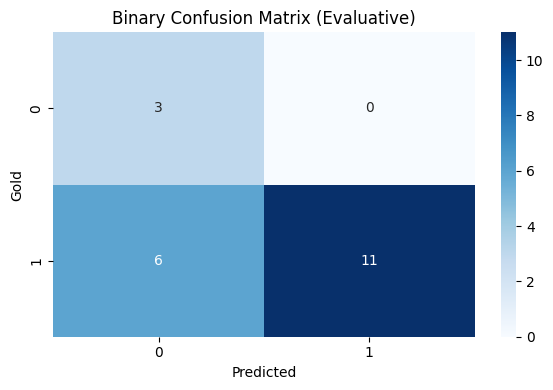

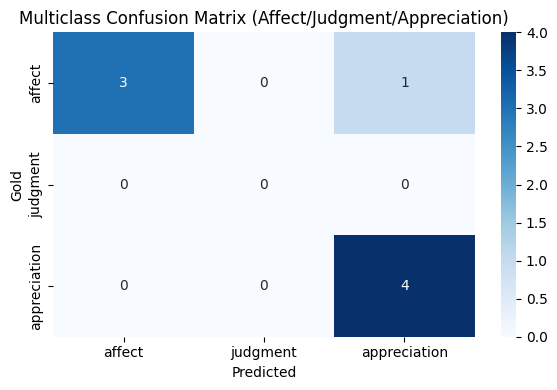

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Gold")
    plt.title(title)
    plt.tight_layout()
    plt.show()


cm_bin = confusion_matrix(gold_binary, pred_binary)

plot_confusion_matrix(
    cm_bin,
    labels=["0", "1"],
    title="Binary Confusion Matrix (Evaluative)"
)

cm_multi = confusion_matrix(
    y_true_multi,
    y_pred_multi,
    labels=["affect", "judgment", "appreciation"]
)

plot_confusion_matrix(
    cm_multi,
    labels=["affect", "judgment", "appreciation"],
    title="Multiclass Confusion Matrix (Affect/Judgment/Appreciation)"
)
